### 할당된 GPU 확인

In [2]:
!nvidia-smi

Tue Jun 15 03:38:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Drive mount

In [3]:
from google.colab import drive
import os, sys

drive.mount('/content/drive')

Mounted at /content/drive


### 필요한 library 및 자료 다운로드

In [4]:
!pip install  mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 46.9MB 109kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 6.6MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595694 sha256=f287d16aa4d8bd7811731193d0fbb5993c454dc09ea465334e431ffc7282167e
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 6.7MB/s 
     |████████████████████████████████| 2.3MB 5.2MB/s 
     |████████████████████████████████| 3.3MB 30.7MB/s 
     |████████████████████████████████| 901kB 38.8MB/s 


In [5]:
#!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [7]:
#from kobert.utils import get_tokenizer
#from kobert.pytorch_kobert import get_pytorch_kobert_model

In [8]:
from transformers import AdamW, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

### gpu 사용

In [9]:
##GPU 사용 시
device = torch.device("cuda:0")

### Pretrained bert, vocab download
####vocab은 문장에 있는 단어 나눌 때 사용됨, 형태소 사전같은 걸로 생각하면 된다

In [10]:
#bertmodel, vocab = get_pytorch_kobert_model()
#bertmodel = get_kobert_model()

model_path = '/content/drive/MyDrive/kobert_from_pretrained'
vocab_file = '/content/drive/MyDrive/kobert_news_wiki_ko_cased-1087f8699e.spiece'
bertmodel = BertModel.from_pretrained(model_path)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file, padding_token='[PAD]')

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### 우리가 사용하는 dataset 가져와서 train, validation, test set으로 분류

In [12]:
file1 = '/content/drive/MyDrive/problem_ner_multilabel_re_addonlykorean_replacevariable_replacenumber.csv'
file2 = '/content/drive/MyDrive/problem_ner_min_re_275_addonlykorean_replacevariable_replacenumber.csv'
file3 = '/content/drive/MyDrive/ner_preprocessed_complete_re_drop_addonlykorean_replacevariable_replacenumber_8_label_single.csv'

In [13]:
df = pd.read_csv(file3)

In [14]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1',
       'id', 'tag', 'title', 'description', 'input', 'output', 'ner_decode',
       'list_ner', 'ner_preprocessed_desc', 'only_korean_desc',
       'only_korean_input', 'only_korean_output',
       'only_korean_variablenumber_desc', 'only_korean_variablenumber_input',
       'only_korean_variablenumber_output', 'variablenumber_desc',
       'variablenumber_input', 'variablenumber_output',
       'desc_variabel_renumber', 'input_variabel_renumber',
       'output_variabel_renumber', 'desc_variabel_renumber_0',
       'input_variabel_renumber_0', 'output_variabel_renumber_0'],
      dtype='object')

In [15]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7, stratify = df.tag.values)
valid_df, test_df = train_test_split(remaining, random_state=46, train_size = 0.5, stratify = remaining.tag.values)

### tag가 string이기 때문에 숫자로 바꾸기 위해서 encoder라는 것을 사용한다
### encoder를 사용하면 쉽게 tag의 문자를 숫자로 바꿔준다

In [16]:
print(train_df.shape, valid_df.shape, test_df.shape)

#라벨의 숫자화
label = df['tag'].values
encoder = LabelEncoder()
encoder.fit(label)

(2842, 31) (609, 31) (609, 31)


LabelEncoder()

### label별 data 개수가 불균형한 경우 학습에 영향을 주기 때문에 loss 가중치를 조정하여 해결할 수도 있다
### 우리 학습할 땐 사용 안했음

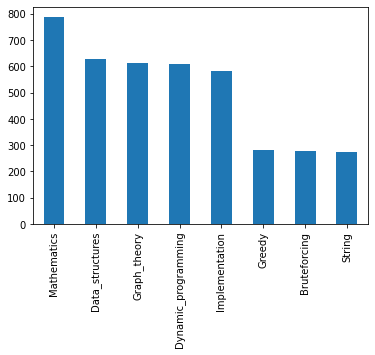

['Bruteforcing' 'Data_structures' 'Dynamic_programming' 'Graph_theory'
 'Greedy' 'Implementation' 'Mathematics' 'String']
tensor([1.8255, 0.8068, 0.8333, 0.8279, 1.7933, 0.8690, 0.6440, 1.8388])


In [17]:
df.tag.value_counts().plot(kind='bar')
plt.show()

class_loss = [df.tag.value_counts()[i] for i in encoder.classes_ ]
class_weights = compute_class_weight('balanced', np.unique(df['tag']), df['tag'])
weights= torch.tensor(class_weights,dtype=torch.float)
print(encoder.classes_)
print(weights)

In [18]:
### 분류한 dataset을 형식에 맞게 변환하는 코드

In [19]:
def set_data(dataframe) :
  dataset = []
  tmp = encoder.transform(dataframe['tag'])
  i = 0
  for index, row in dataframe.iterrows():
   problem = row['desc_variabel_renumber_0']
   if not pd.isna(row['input_variabel_renumber_0']) :
      problem = problem + row['input_variabel_renumber_0']

   dataset.append([problem , tmp[i]])
   i = i + 1
  return dataset

In [20]:
dataset_train = set_data(train_df)
dataset_valid = set_data(valid_df)
dataset_test = set_data(test_df)

### tokenizer는 문장을 단어로 나눠주는 역할을 한다

In [21]:
#tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(vocab_file, vocab, lower=False)

### 데이터셋 관련 코드

In [22]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


### model parameter


In [40]:
## Setting parameters
max_len = 512
batch_size = 8
warmup_ratio = 0.1
num_epochs = 8
max_grad_norm = 1
log_interval = 200
learning_rate =  1e-5

### 데이터 셋 표준화 과정

In [24]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_valid = BERTDataset(dataset_valid, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [25]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 우리가 사용할 모델 정의 
### bert 모델 뒤에 single layer 추가해서 softmax로 분류하는 방식

In [26]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)

        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

### model 할당

In [43]:
model = BERTClassifier(bertmodel, num_classes=8, dr_rate=0.1).to(device) 

In [44]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01}, #0.01
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0} #0.0
]

### optimizer와 loss function 설정

In [45]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(weight = weights).to(device)
#loss_fn = nn.CrossEntropyLoss()

### 잘 모르겠음 ;;

In [46]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [47]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

### 정확도 계산하는 함수

In [48]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# train 시키는 코드

In [49]:
#torch.cuda.empty_cache()

In [50]:
train_loss_values = []
validation_loss_values = [] 
train_acc_list = []
validation_acc_list = []
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    validation_loss = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_loss += loss.item()
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(train_loss)
    train_acc_list.append(train_acc / len(train_dataloader))

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        
        validation_loss += loss.item() 
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    validation_loss = validation_loss / len(valid_dataloader)
    validation_loss_values.append(validation_loss)
    validation_acc_list.append(test_acc / len(valid_dataloader))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.0306262969970703 train acc 0.0
epoch 1 batch id 201 loss 1.570780634880066 train acc 0.39552238805970147

epoch 1 train acc 0.5319522471910112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 test acc 0.3961038961038961


epoch 2 batch id 1 loss 1.0776317119598389 train acc 0.625
epoch 2 batch id 201 loss 0.8801144957542419 train acc 0.763681592039801

epoch 2 train acc 0.7686095505617978



epoch 2 test acc 0.362012987012987


epoch 3 batch id 1 loss 0.8105197548866272 train acc 0.625
epoch 3 batch id 201 loss 0.7782917618751526 train acc 0.822139303482587

epoch 3 train acc 0.8314606741573034



epoch 3 test acc 0.3782467532467532


epoch 4 batch id 1 loss 0.39426398277282715 train acc 1.0
epoch 4 batch id 201 loss 0.6729050874710083 train acc 0.8756218905472637

epoch 4 train acc 0.8781601123595506



epoch 4 test acc 0.37012987012987014


epoch 5 batch id 1 loss 0.3956981599330902 train acc 0.75
epoch 5 batch id 201 loss 0.45004838705062866 train acc 0.8936567164179104

epoch 5 train acc 0.8964185393258427



epoch 5 test acc 0.3652597402597403


epoch 6 batch id 1 loss 0.22031913697719574 train acc 0.875
epoch 6 batch id 201 loss 0.15546700358390808 train acc 0.9154228855721394

epoch 6 train acc 0.918188202247191



epoch 6 test acc 0.36363636363636365


epoch 7 batch id 1 loss 0.1252417266368866 train acc 1.0
epoch 7 batch id 201 loss 0.32592669129371643 train acc 0.9216417910447762

epoch 7 train acc 0.9252106741573034



epoch 7 test acc 0.3538961038961039


epoch 8 batch id 1 loss 0.08184115588665009 train acc 1.0
epoch 8 batch id 201 loss 0.2796550989151001 train acc 0.9365671641791045

epoch 8 train acc 0.9367977528089888



epoch 8 test acc 0.35064935064935066


### loss graph 그린다

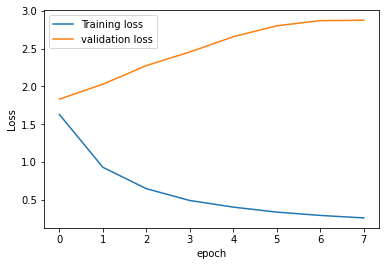

In [51]:
plt.plot(np.array(train_loss_values), label='Training loss')
plt.plot(np.array(validation_loss_values), label='validation loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 정확도 graph 그림

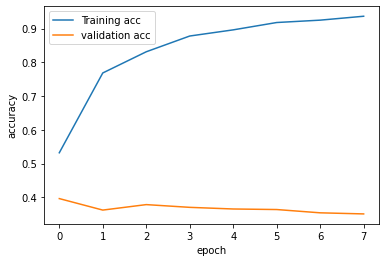

In [52]:
plt.plot(np.array(train_acc_list), label='Training acc')
plt.plot(np.array(validation_acc_list), label='validation acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### predict하는 코드

In [53]:
pred_list = []
test_label = []

with torch.no_grad():
  model.eval()
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    test_label.extend(label)
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    _, pred_value = torch.max(out, 1)
    pred_list.extend(pred_value.cpu().numpy())

pred_list = [a.squeeze().tolist() for a in pred_list]
test_label = [a.squeeze().tolist() for a in test_label]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 알고리즘별 정확도 출력하는 코드
#### precision : label이 a일 때 a라고 예측한 확률
#### recall : a라고 예측했을 때, a인 확률
#### f1-score : recall과 precision의 조화평균
#### support : 개수
#### 관점에 따라 사용하는 것이 다르다고 생각하면 됨 

In [54]:
target_name = encoder.classes_
print(classification_report(test_label, pred_list, target_names=target_name, zero_division = 0))

                     precision    recall  f1-score   support

       Bruteforcing       0.10      0.07      0.08        42
    Data_structures       0.43      0.38      0.40        94
Dynamic_programming       0.31      0.33      0.32        91
       Graph_theory       0.48      0.53      0.51        92
             Greedy       0.12      0.14      0.13        42
     Implementation       0.42      0.41      0.41        88
        Mathematics       0.46      0.45      0.45       118
             String       0.56      0.60      0.57        42

           accuracy                           0.39       609
          macro avg       0.36      0.36      0.36       609
       weighted avg       0.39      0.39      0.39       609



### y축 = input x축 = 예측 결과, 대각선의 확률이 a일 때 a로 예측한 확률

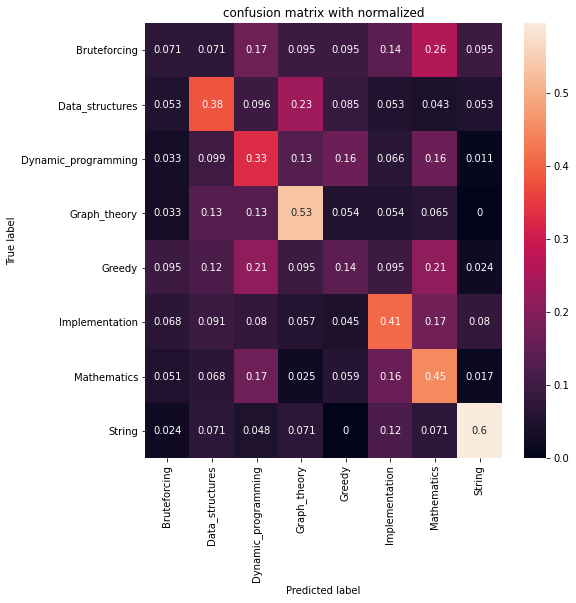

In [55]:
cm = confusion_matrix(test_label, pred_list)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, target_name, target_name)
plt.figure(figsize=(8, 8))
plt.title('confusion matrix with normalized')
sn.heatmap(df_cm, annot = True)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()